# Imports

In [45]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import copy
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
import os

# Check if there is any gpus

In [46]:
#if torch.cuda.is_available():
print(f"Number of GPUs available: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
# else:
#     print("No GPUs available.")

Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU


# Preparing data

Number of classes: 10
Class names: ['AFRICAN LEOPARD', 'CARACAL', 'CHEETAH', 'CLOUDED LEOPARD', 'JAGUAR', 'LIONS', 'OCELOT', 'PUMA', 'SNOW LEOPARD', 'TIGER']
Number of training images: 1946
Number of validation images: 238
Number of test images: 255


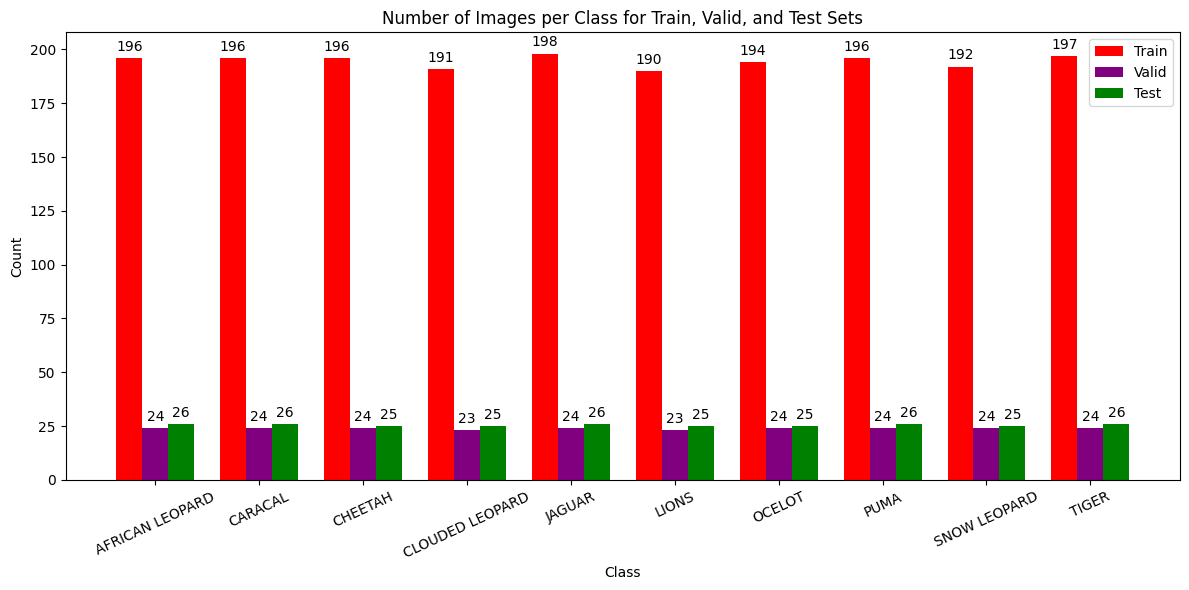

In [47]:

# Define paths to the dataset directories
train_path = './myArchive/train'
test_path = './myArchive/test'
valid_path = './myArchive/valid'

img_size = 32
batch_size = 16

# Define transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
train_dataset = ImageFolder(train_path, transform=transform)
valid_dataset = ImageFolder(valid_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get class names
class_names = train_dataset.classes
num_classes = len(class_names)

# Print number of images and classes
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(valid_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

# Initialize count dictionaries
train_counts = {label: 0 for label in class_names}
valid_counts = {label: 0 for label in class_names}
test_counts = {label: 0 for label in class_names}

def update_class_counts(loader, class_counts):
    for batch_data, batch_labels in loader:
        for label in batch_labels:
            class_label = class_names[label]
            class_counts[class_label] += 1
            
# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Update counts from each DataLoader
update_class_counts(train_loader, train_counts)
update_class_counts(valid_loader, valid_counts)
update_class_counts(test_loader, test_counts)

# Create a bar chart with different colors for each dataset type
x = np.arange(len(class_names))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the bars
rects1 = ax.bar(x - width, train_counts.values(), width, label='Train', color='r')
rects2 = ax.bar(x, valid_counts.values(), width, label='Valid', color='purple')
rects3 = ax.bar(x + width, test_counts.values(), width, label='Test', color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Number of Images per Class for Train, Valid, and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=25)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

# Training

In [43]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 8 * 8, 64)  # Assuming img_size=32, after 2 pooling layers, size is 8x8
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to save checkpoints
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

# Instantiate the model, loss function, and optimizer
model = CNNModel(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
checkpoint_path = "training_1/cp.weights.pth"

train_accuracies = []
valid_accuracies = []
train_f1_scores = []
valid_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
    
    # Validate the model
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
    
    valid_accuracy = accuracy_score(all_val_labels, all_val_preds)
    valid_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    valid_accuracies.append(valid_accuracy)
    valid_f1_scores.append(valid_f1)
    
    print(f"Validation Loss: {val_loss/len(valid_loader):.4f}, Valid Accuracy: {valid_accuracy:.4f}, Valid F1: {valid_f1:.4f}")
    
    # Save checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, filename=checkpoint_path)

Epoch [1/20], Loss: 2.2489, Train Accuracy: 0.1531, Train F1: 0.1232
Validation Loss: 2.0994, Valid Accuracy: 0.2521, Valid F1: 0.1864
Epoch [2/20], Loss: 2.0823, Train Accuracy: 0.2569, Train F1: 0.2338
Validation Loss: 1.9486, Valid Accuracy: 0.2689, Valid F1: 0.2322
Epoch [3/20], Loss: 1.9723, Train Accuracy: 0.2847, Train F1: 0.2651
Validation Loss: 1.8548, Valid Accuracy: 0.3025, Valid F1: 0.2621
Epoch [4/20], Loss: 1.8187, Train Accuracy: 0.3422, Train F1: 0.3308
Validation Loss: 1.8632, Valid Accuracy: 0.3109, Valid F1: 0.3082
Epoch [5/20], Loss: 1.7350, Train Accuracy: 0.3623, Train F1: 0.3564
Validation Loss: 1.6961, Valid Accuracy: 0.3319, Valid F1: 0.3014
Epoch [6/20], Loss: 1.5454, Train Accuracy: 0.4435, Train F1: 0.4396
Validation Loss: 1.6536, Valid Accuracy: 0.3950, Valid F1: 0.3689
Epoch [7/20], Loss: 1.3774, Train Accuracy: 0.5103, Train F1: 0.5047
Validation Loss: 1.5115, Valid Accuracy: 0.4580, Valid F1: 0.4304
Epoch [8/20], Loss: 1.2247, Train Accuracy: 0.5586, Tra

In [49]:
# Define custom head
class CustomHead(nn.Module):
    def __init__(self, num_classes):
        super(CustomHead, self).__init__()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, 64)
        self.output = nn.Linear(64, num_classes)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.activation(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

# Load pre-trained EfficientNetB0
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(class_names))

# Freeze the base model
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with custom head
model._fc = CustomHead(len(class_names))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and criterion
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
    
    valid_accuracy = valid_correct / valid_total
    print(f"Validation Loss: {valid_loss/len(valid_loader):.4f}, Validation Accuracy: {valid_accuracy:.4f}")

Loaded pretrained weights for efficientnet-b0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 1280x64)

# Testing the model

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

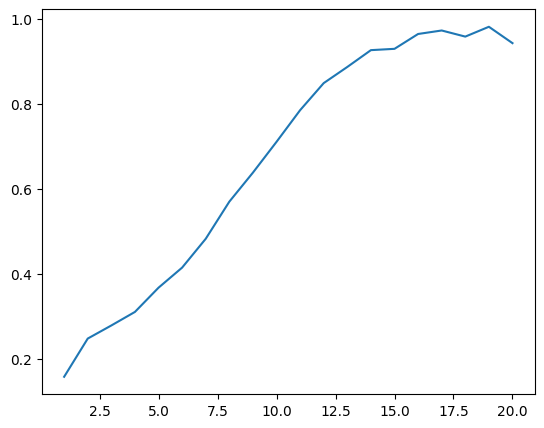

In [42]:
# Plot accuracy and F1 score
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1_scores, label='Train F1 Score')
plt.plot(epochs, valid_f1_scores, label='Valid F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Evaluate models
def evaluate_model(model, dataloader):
    model.eval()
    corrects = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = corrects.double() / total
    return accuracy, all_labels, all_preds

# Evaluate the trained models on the test dataset
test_dataloader = test_loader

for model_name, model in [('original_model', original_model), ('effnet_model', effnet_model)]:
    accuracy, true_labels, predicted_labels = evaluate_model(model, test_dataloader)
    print(f'{model_name} Test Accuracy: {accuracy:.4f}')
    
    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f'{model_name} F1 Score: {f1:.4f}')
    
    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(f'{model_name} Classification Report:\n', report)

original_model Test Accuracy: 0.4627
original_model F1 Score: 0.4632
original_model Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.53      0.31      0.39        26
        CARACAL       0.44      0.62      0.52        26
        CHEETAH       0.44      0.48      0.46        25
CLOUDED LEOPARD       0.48      0.40      0.43        25
         JAGUAR       0.41      0.46      0.44        26
          LIONS       0.56      0.36      0.44        25
         OCELOT       0.31      0.40      0.35        25
           PUMA       0.38      0.50      0.43        26
   SNOW LEOPARD       0.67      0.56      0.61        25
          TIGER       0.58      0.54      0.56        26

       accuracy                           0.46       255
      macro avg       0.48      0.46      0.46       255
   weighted avg       0.48      0.46      0.46       255

effnet_model Test Accuracy: 0.5647
effnet_model F1 Score: 0.5551
effnet_model Classificatio